In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM

/var/folders/3r/b1hvjmb91q77lp2dj1f9_w980000gn/T/ipykernel_6687/3356426969.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Data Preprocessing 
def preprocess_data(df):
    # Drop unwanted columns
    df.drop(['id', 'proto', 'service', 'state'], axis=1, inplace=True)

    # Handle missing values if any
    df.dropna(inplace=True)
    
    # Encode categorical variables
    cat_cols = ['attack_cat','label']
    encoder = LabelEncoder()
    for col in cat_cols:
        df[col] = encoder.fit_transform(df[col])
        
    # Standardize numerical variables
    num_cols = df.select_dtypes(include='number').columns.tolist()
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

# Function for Plotting Histograms
def plot_histograms(df, num_cols):
    df[num_cols].hist(figsize=(50, 45))
    plt.show()

# Function for Plotting Heatmap
def plot_heatmap(df):
    corr = df.corr()
    plt.figure(figsize=(18, 18))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.show()

# Function for Plotting Box Plots
def plot_boxplots(df, num_cols, target_col):
    for col in num_cols:
        sns.boxplot(x=target_col, y=col, data=df)
        plt.show()
        print('\n')
    
# Function for Model Training and Evaluation
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    # Define empty dictionaries to store evaluation metrics
    fpr_tpr_dict = {}
    roc_auc_scores = {}
    p_r_dict = {}
    pr_auc_scores = {}
    accuracy_scores = {}
        
    for model_name, model in models.items():
        # Check if the model is a Keras model
        if isinstance(model, Sequential):
            # Compile the Keras model
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
        # Train the model
        model.fit(X_train, y_train)

        # Predict probabilities on the test set
        if isinstance(model, Sequential):
            y_pred_probs = model.predict(X_test)
            y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
        else:
            y_pred = model.predict(X_test)

        # Compute Evaluation metrics - accuracy, confusion matrix, classification report, ROC curve, precision-recall curve
        accuracy_scores[model_name] = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        fpr_tpr_dict[model_name] = (fpr, tpr)
        roc_auc_scores[model_name] = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        p_r_dict[model_name] = (precision, recall)
        pr_auc_scores[model_name] = auc(recall, precision)
        
        print(f'{model_name} Accuracy:', accuracy_scores[model_name])
        print(f'{model_name} Confusion Matrix:\n', conf_matrix)
        print(f'{model_name} Classification Report:\n', classification_rep)

        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_scores[model_name])
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
        
        # Plot Precision-Recall Curve
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc_scores[model_name])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc="lower left")
        plt.show()
    return roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict

def plot_evaluation_curves(roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict, model_type):
    # Plotting ROC Curves
    plt.figure(figsize=(10, 5))
    for model_name, (fpr, tpr) in fpr_tpr_dict.items():
        roc_auc = roc_auc_scores[model_name]
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves of {model_type} - Training Data')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plotting Precision-Recall Curves
    plt.figure(figsize=(10, 5))
    for model_name, (precision, recall) in p_r_dict.items():
        pr_auc = pr_auc_scores[model_name]
        plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves of {model_type} - Training Data')
    plt.legend(loc="lower left")
    plt.show()

    # Print Accuracy Scores
    for model_name, accuracy in accuracy_scores.items():
        print(f'{model_name} Accuracy:', accuracy)
    
    # Plotting Accuracy Scores
    plt.figure(figsize=(10, 5))
    for model_name, accuracy in accuracy_scores.items():
        plt.plot([model_name], [accuracy], marker='o', label=f'{model_name} (Accuracy = {accuracy:.2f})')
    plt.ylim(0, 1.1)
    plt.title(f'Accuracy Scores of {model_type} - Training Data')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [3]:
# Read Data
df = pd.read_csv('/Users/sanjithapathuri/Library/Mobile Documents/com~apple~CloudDocs/files/MS/CourseWork/CS584 ML/Project/UNSW_NB15_training-set.csv')
df = preprocess_data(df)

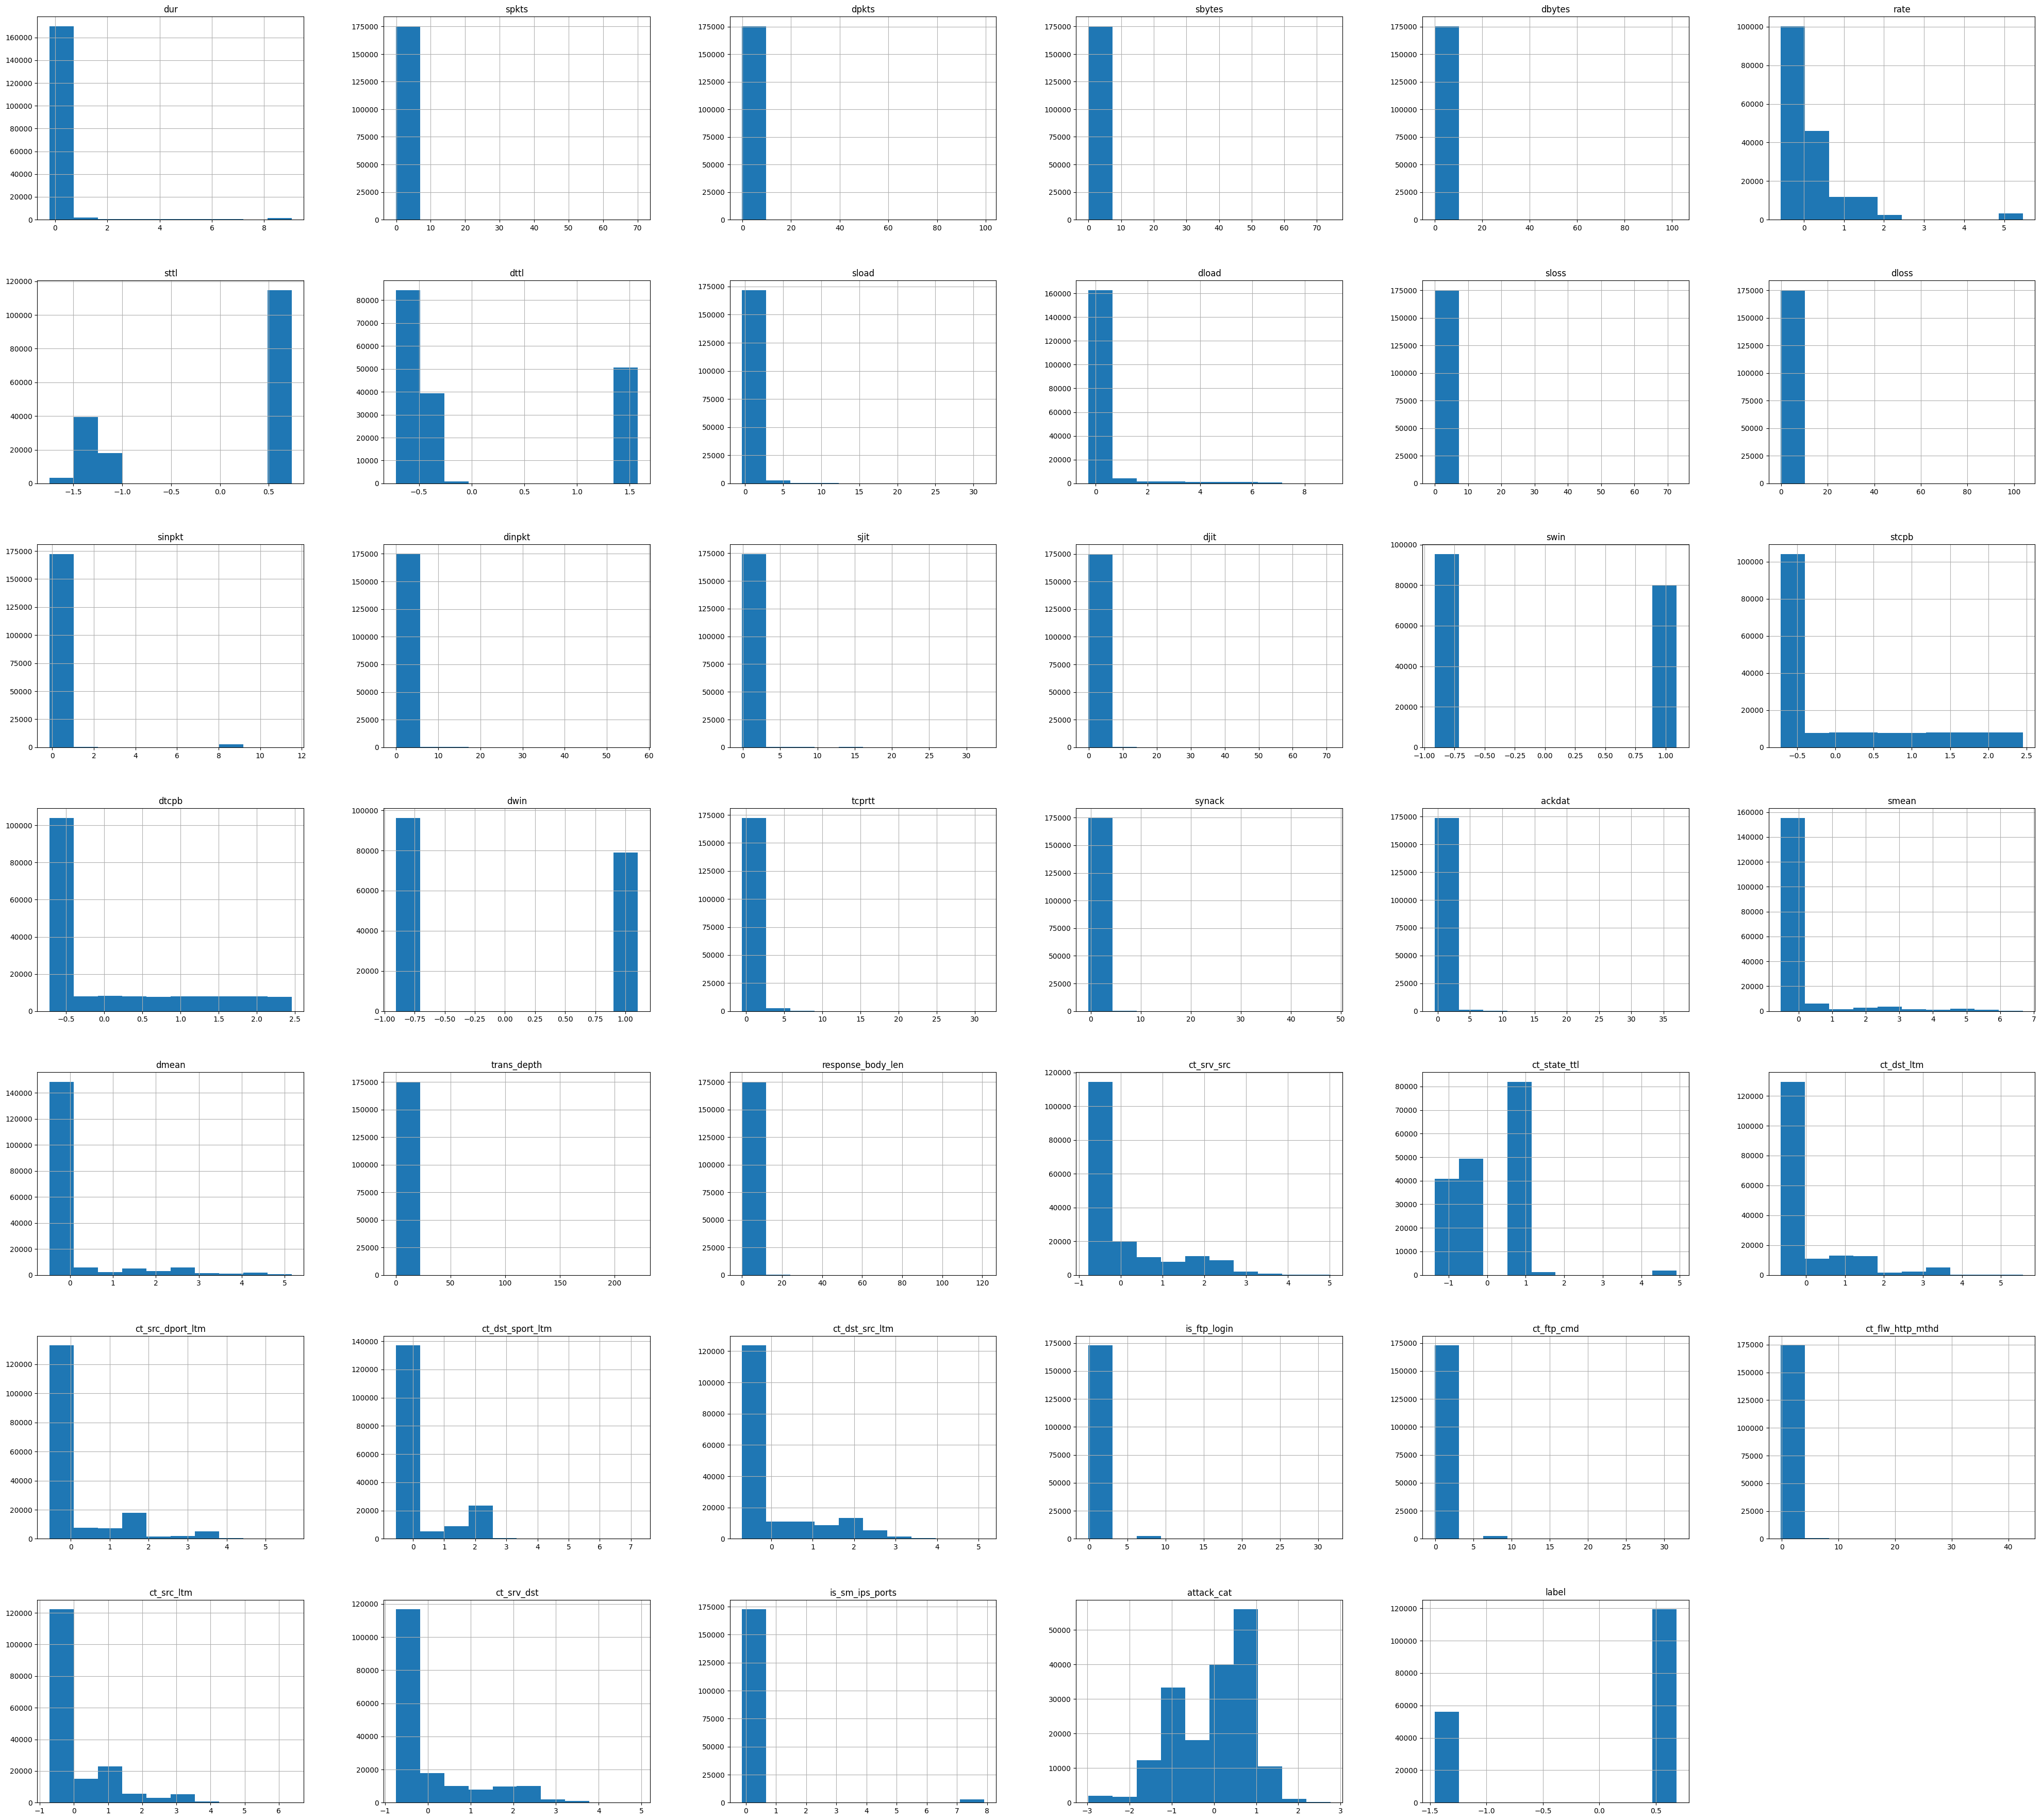

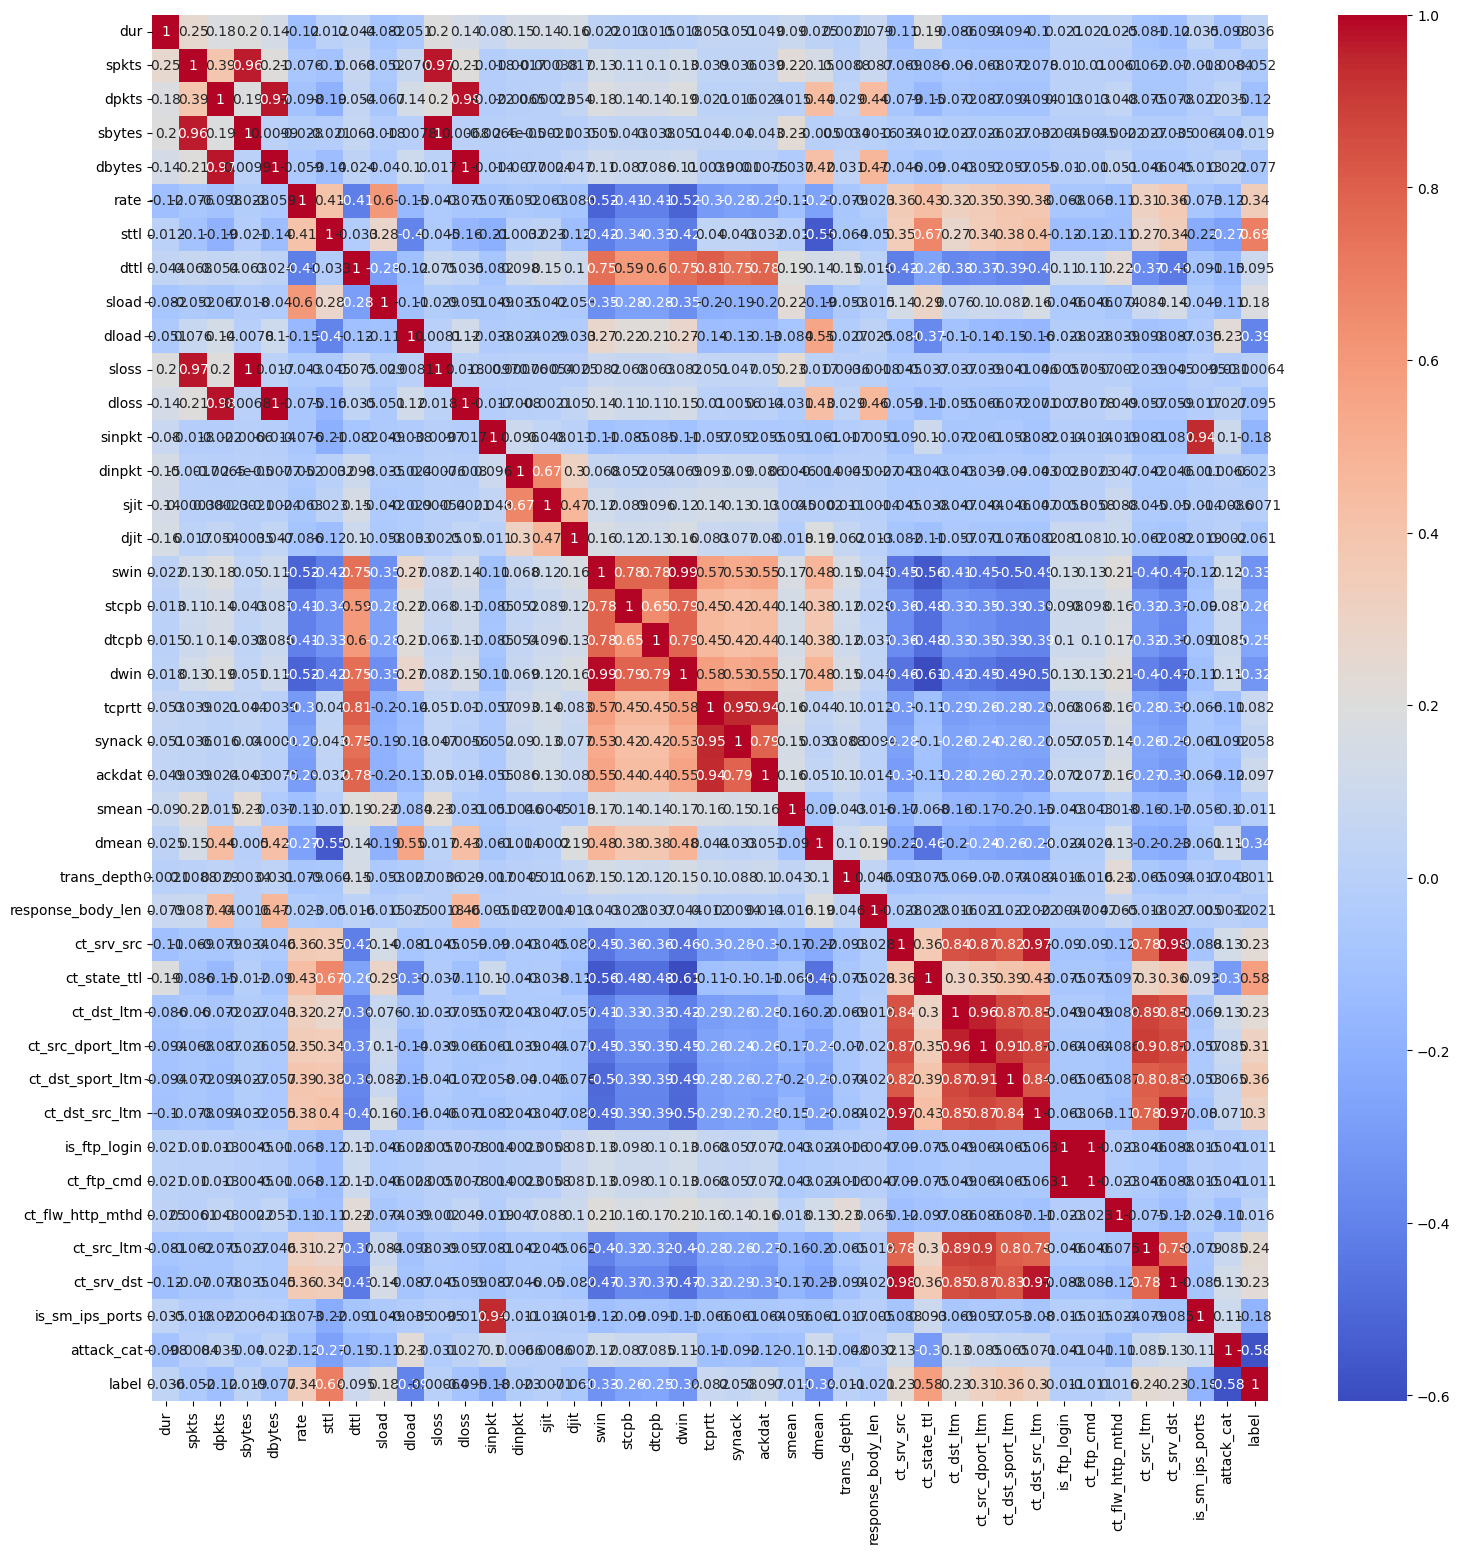

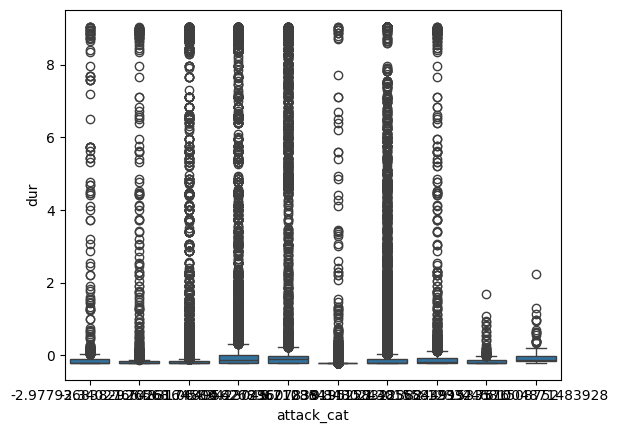

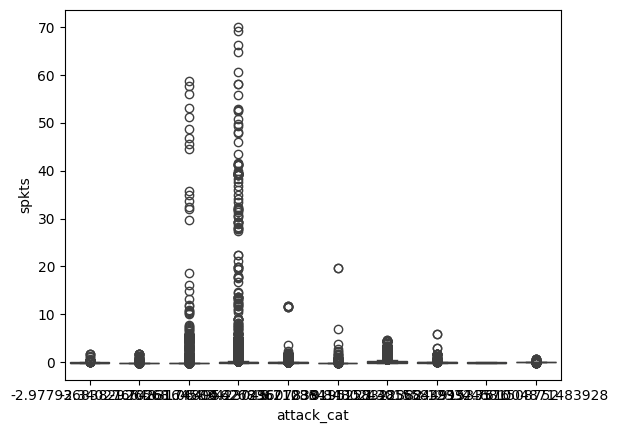

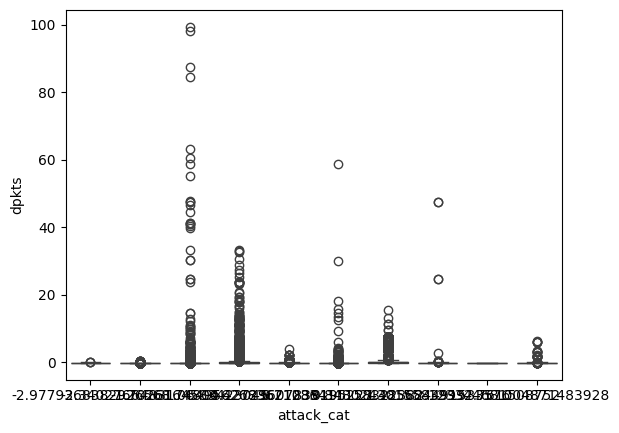

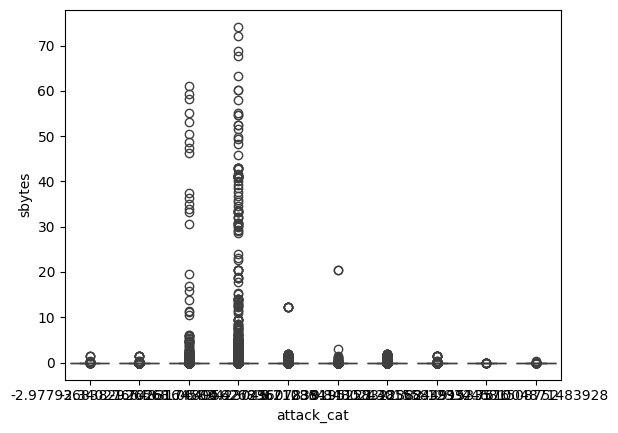

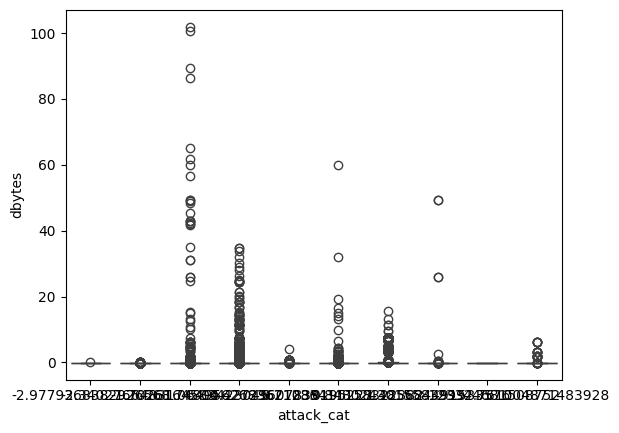

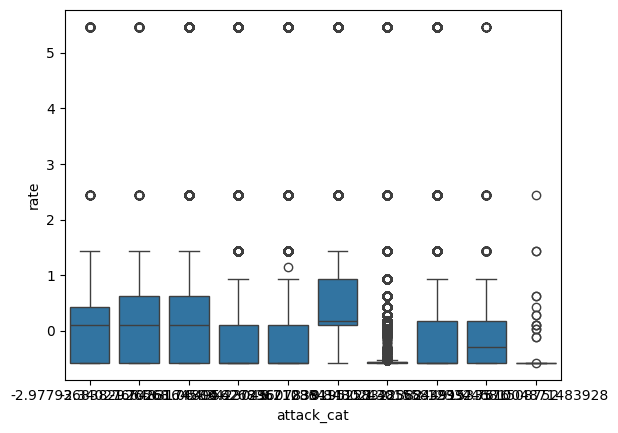

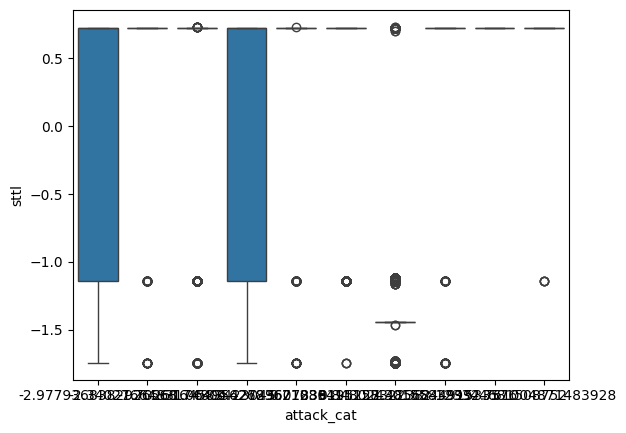

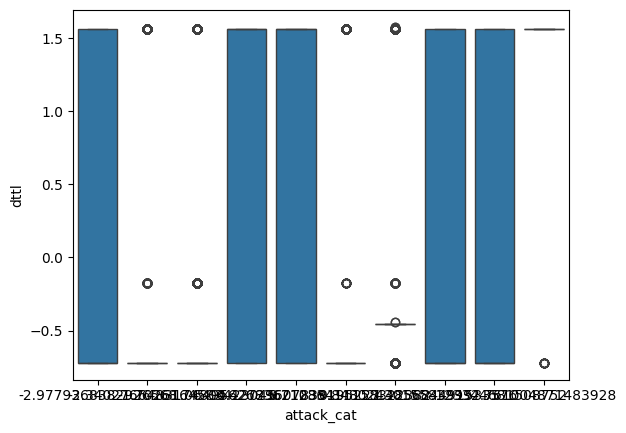

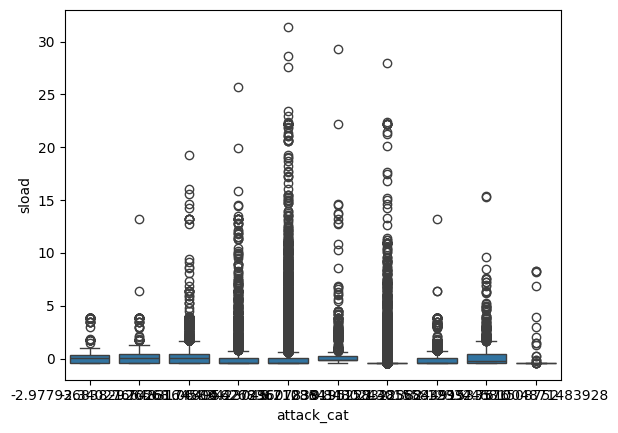

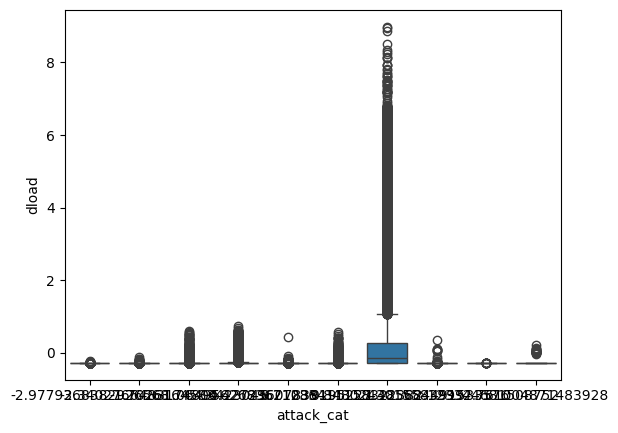

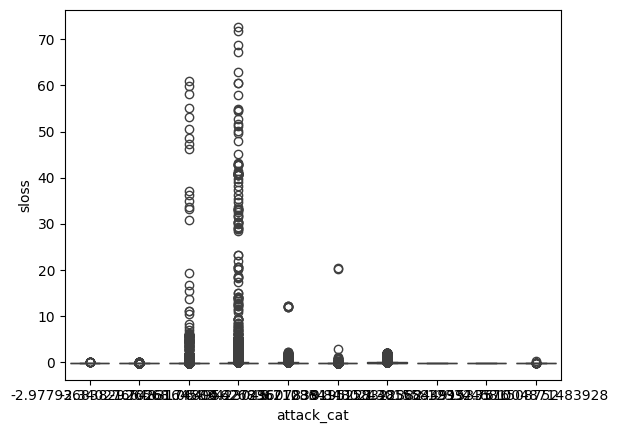

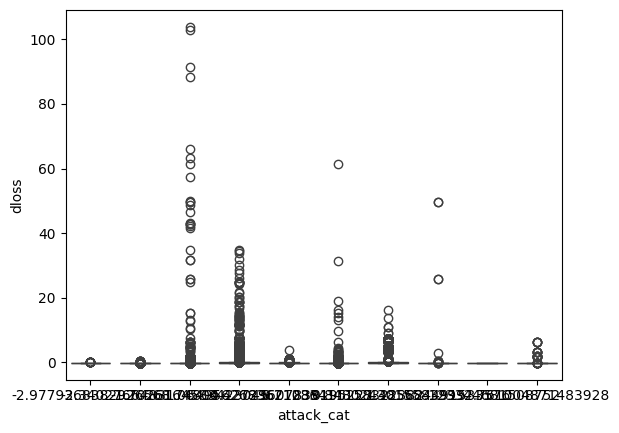

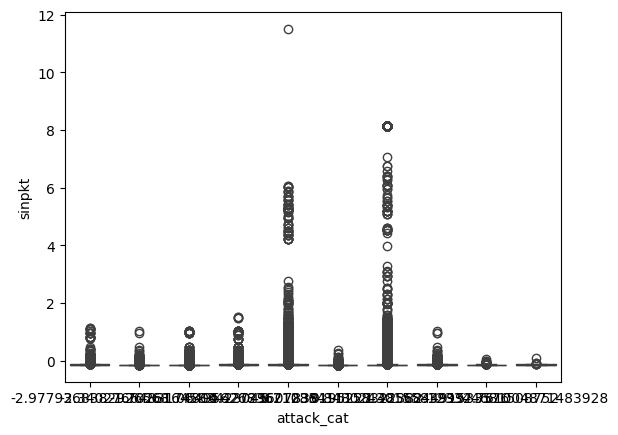

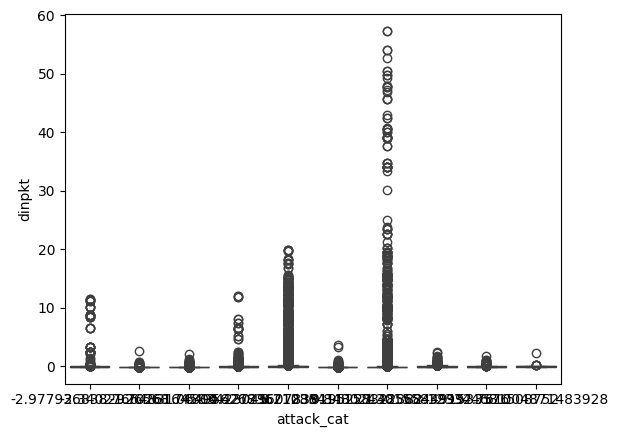

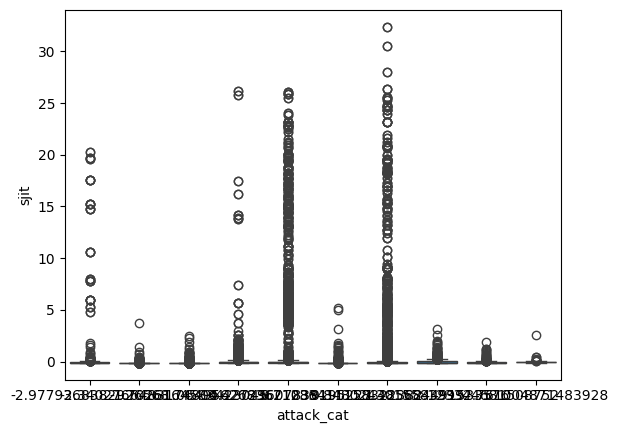

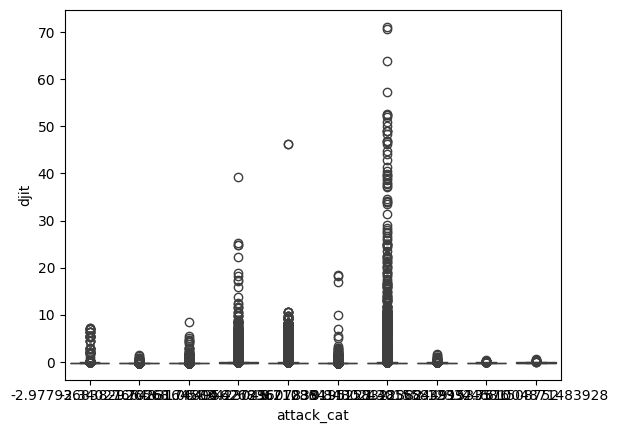

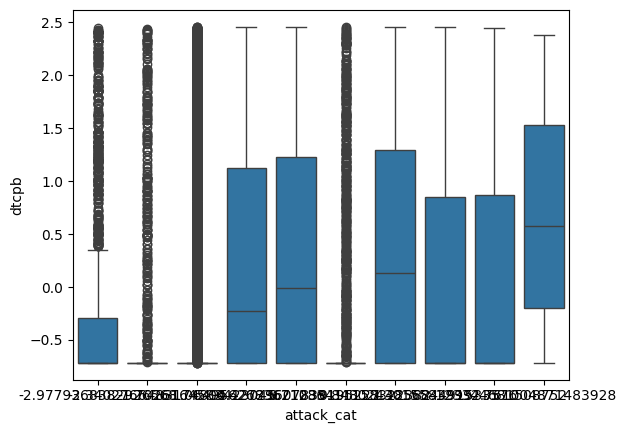

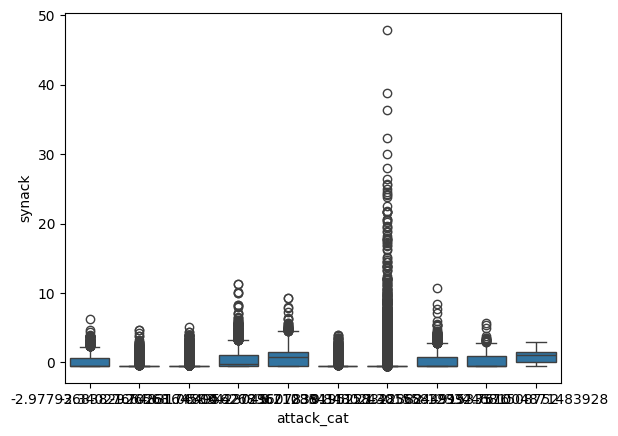

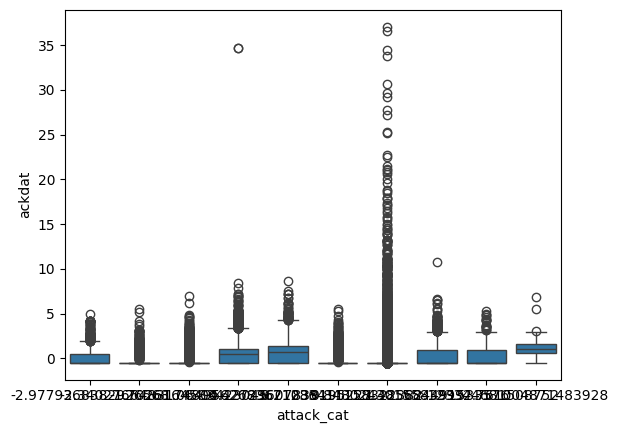

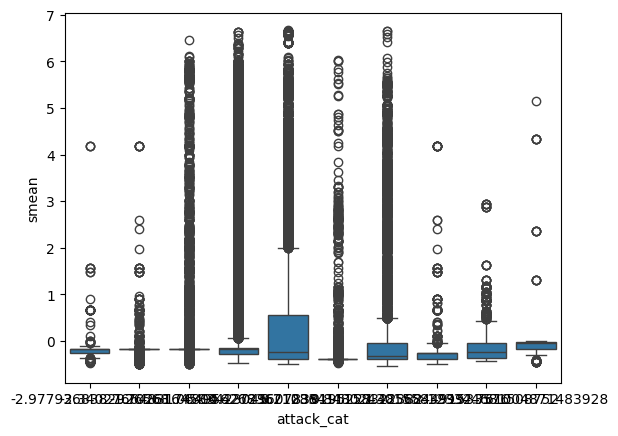

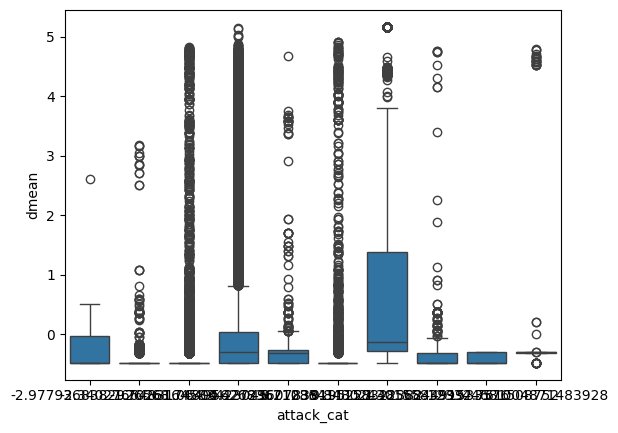

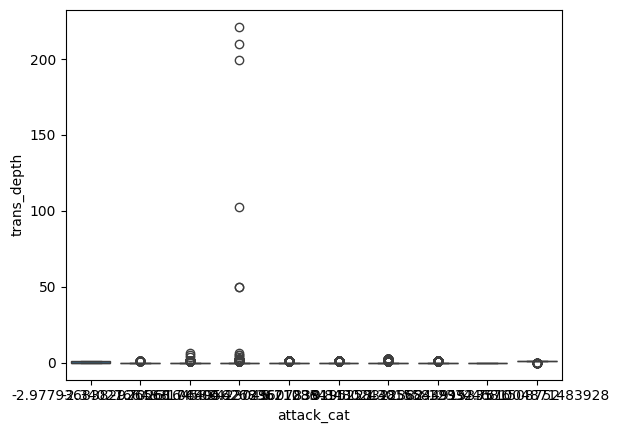

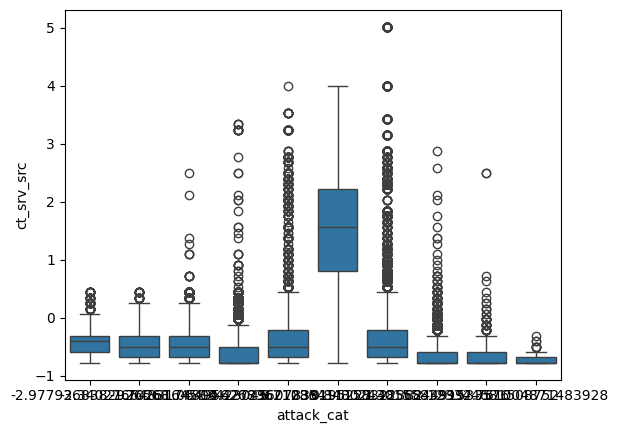

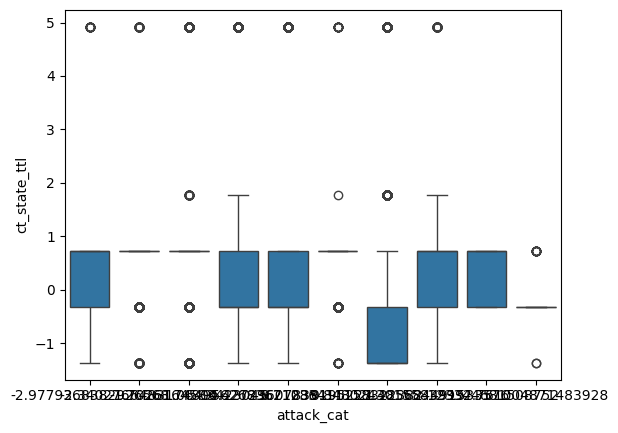

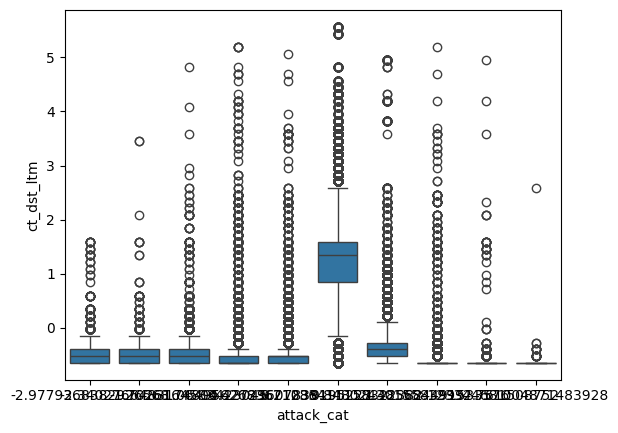

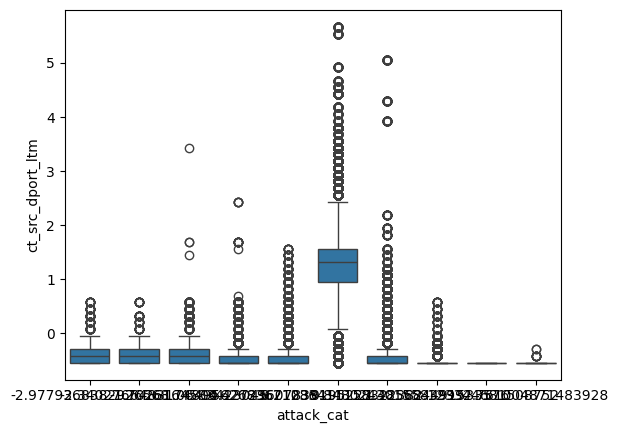

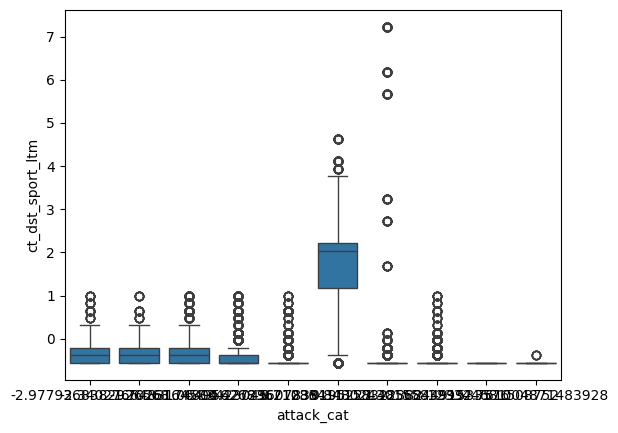

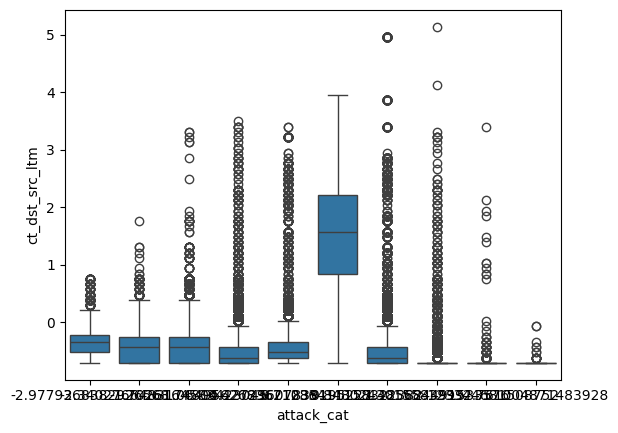

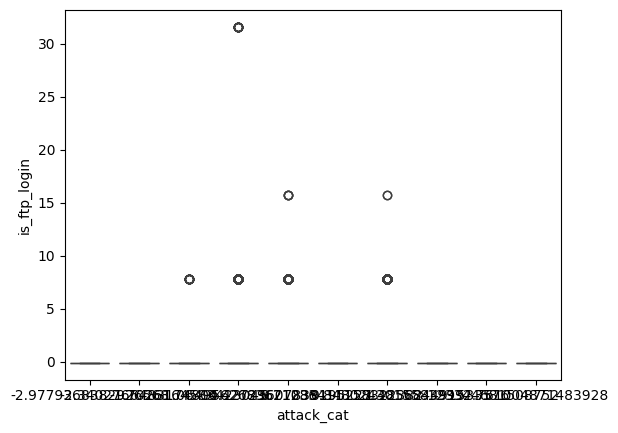

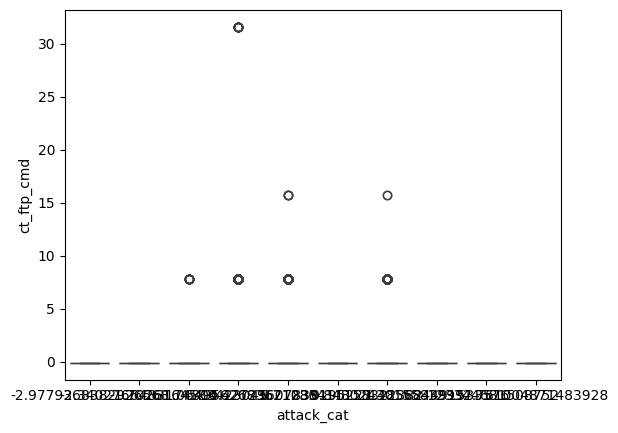

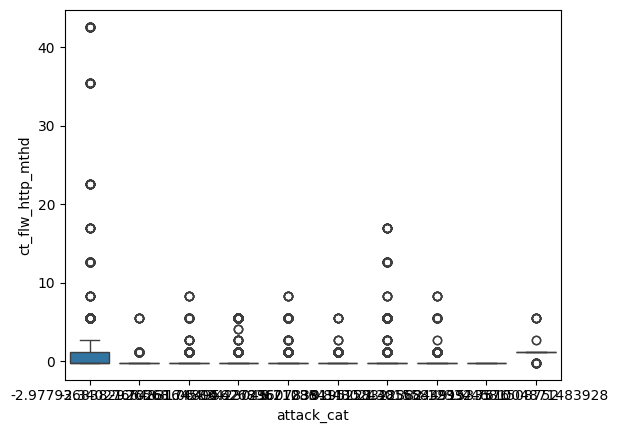

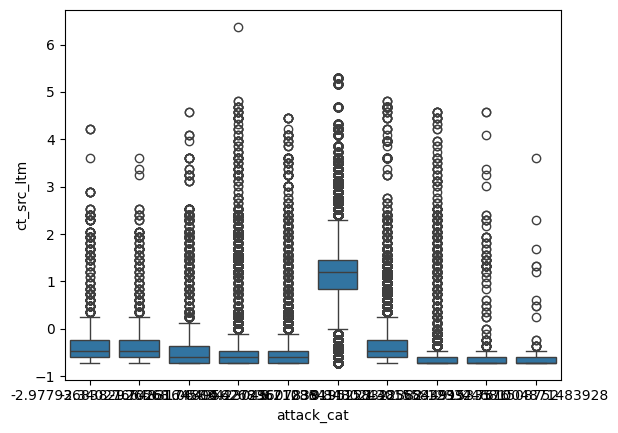

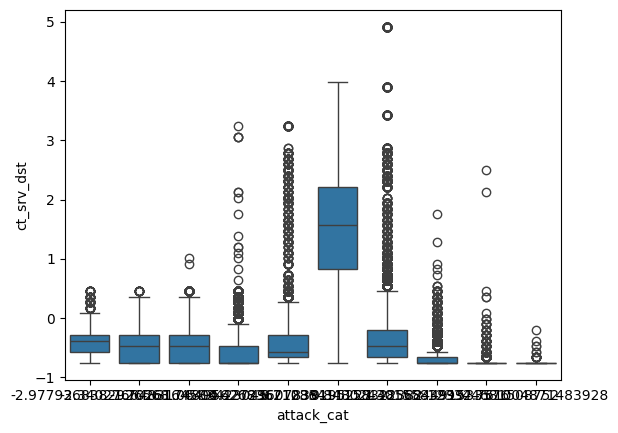

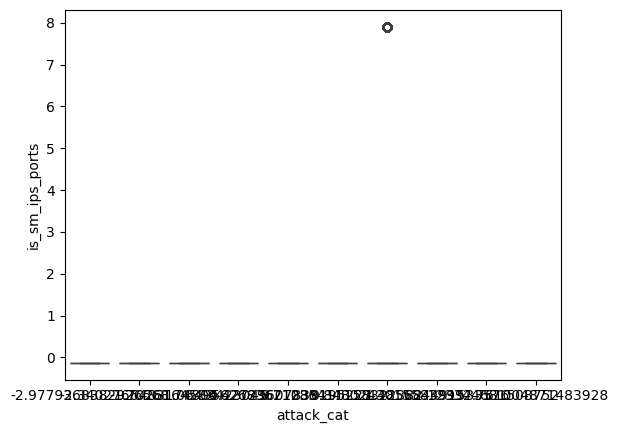

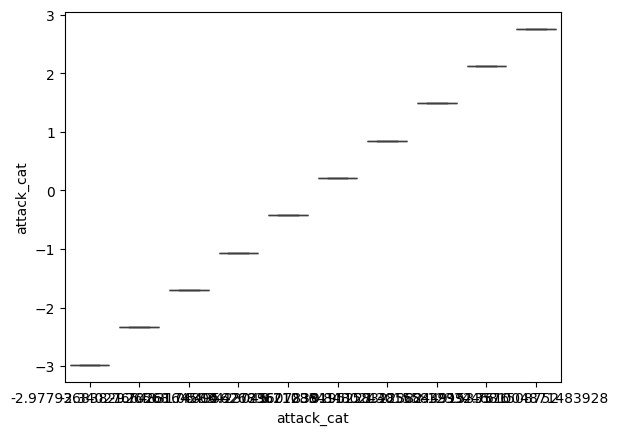

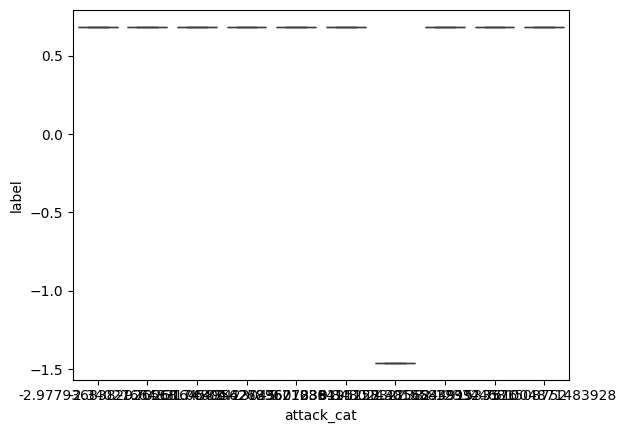

In [4]:
#Exploratory Data Analysis
num_cols = df.select_dtypes(include='number').columns.tolist()
plot_histograms(df, num_cols)
plot_heatmap(df)
plot_boxplots(df, num_cols, 'attack_cat')

In [5]:
X = df.drop(['label'], axis=1)
encoder = LabelEncoder() # Encode the target variable if it represents classes
y = encoder.fit_transform(df['label'])

# Feature Selection
selector = SelectKBest(mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support(indices=True)]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

Logistic Regression Accuracy: 0.8963937418017984
Logistic Regression Confusion Matrix:
 [[13726  3046]
 [ 2404 33427]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83     16772
           1       0.92      0.93      0.92     35831

    accuracy                           0.90     52603
   macro avg       0.88      0.88      0.88     52603
weighted avg       0.90      0.90      0.90     52603



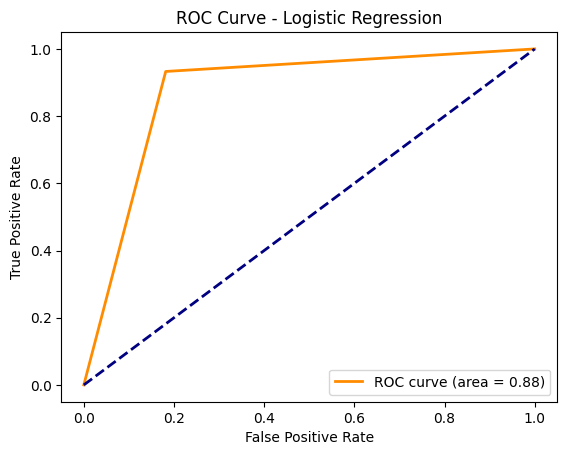

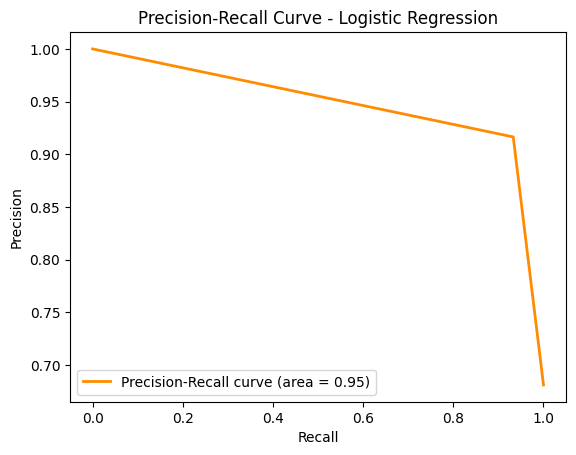

Decision Tree Accuracy: 1.0
Decision Tree Confusion Matrix:
 [[16772     0]
 [    0 35831]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16772
           1       1.00      1.00      1.00     35831

    accuracy                           1.00     52603
   macro avg       1.00      1.00      1.00     52603
weighted avg       1.00      1.00      1.00     52603



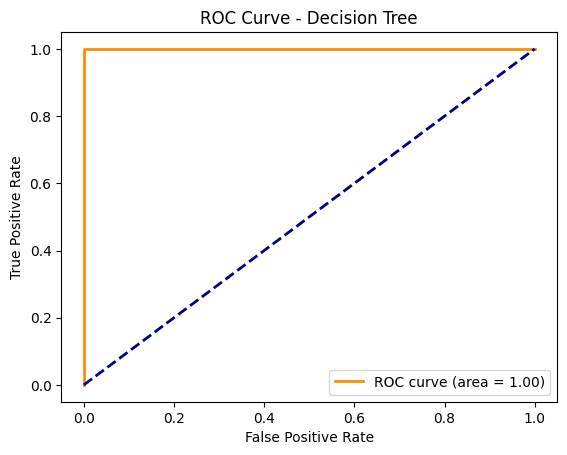

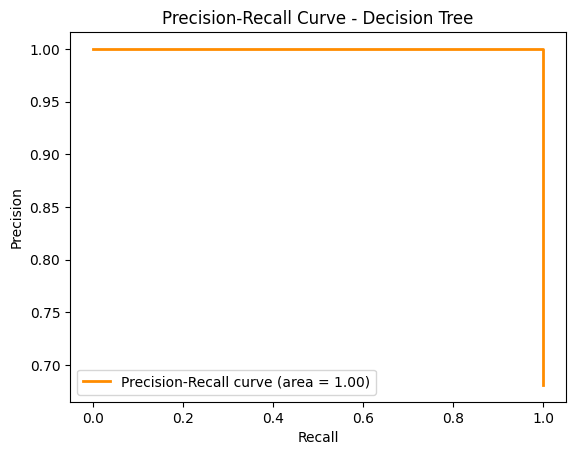

Random Forest Accuracy: 1.0
Random Forest Confusion Matrix:
 [[16772     0]
 [    0 35831]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16772
           1       1.00      1.00      1.00     35831

    accuracy                           1.00     52603
   macro avg       1.00      1.00      1.00     52603
weighted avg       1.00      1.00      1.00     52603



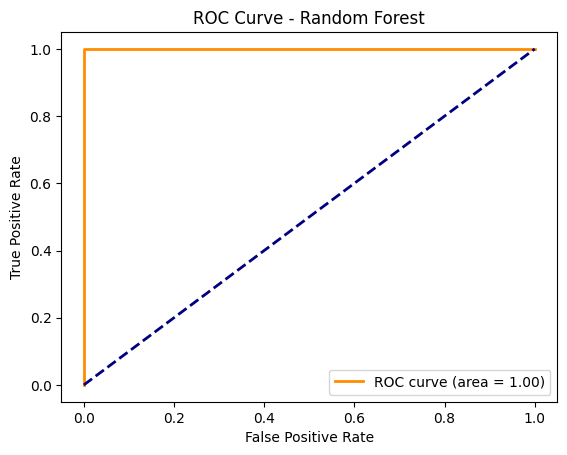

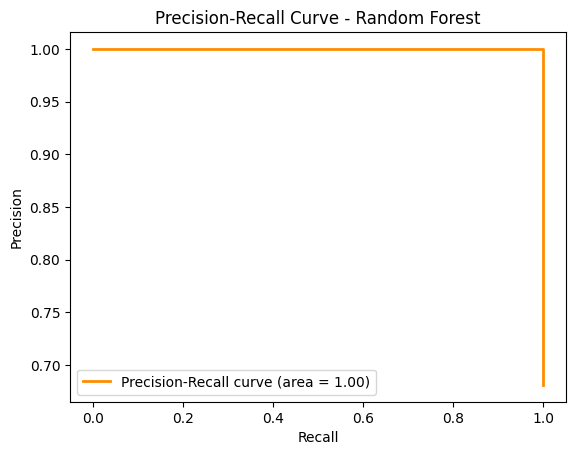

SVM Accuracy: 0.9992585974183982
SVM Confusion Matrix:
 [[16758    14]
 [   25 35806]]
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16772
           1       1.00      1.00      1.00     35831

    accuracy                           1.00     52603
   macro avg       1.00      1.00      1.00     52603
weighted avg       1.00      1.00      1.00     52603



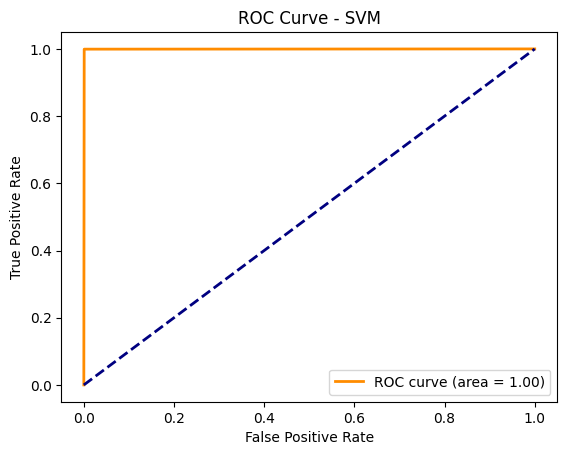

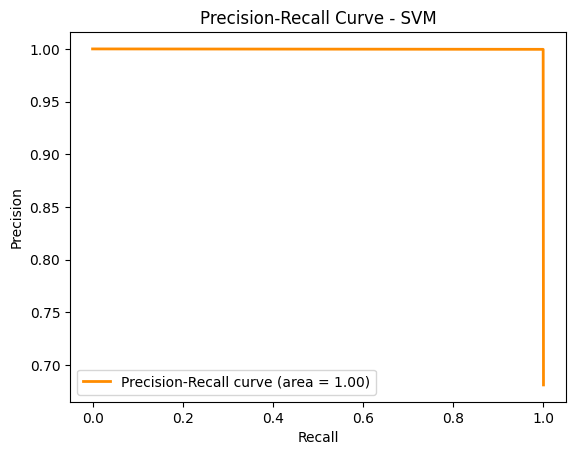

XGBoost Accuracy: 1.0
XGBoost Confusion Matrix:
 [[16772     0]
 [    0 35831]]
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16772
           1       1.00      1.00      1.00     35831

    accuracy                           1.00     52603
   macro avg       1.00      1.00      1.00     52603
weighted avg       1.00      1.00      1.00     52603



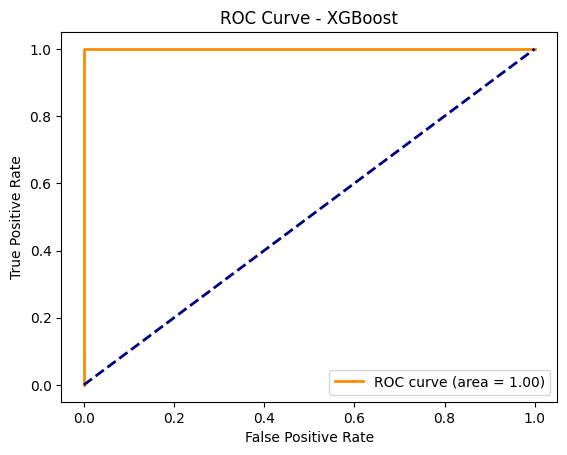

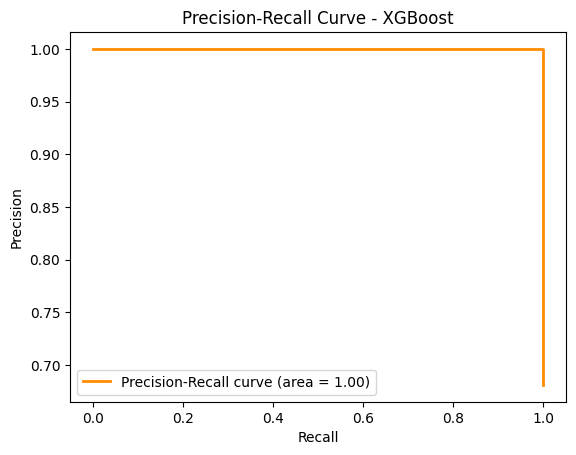

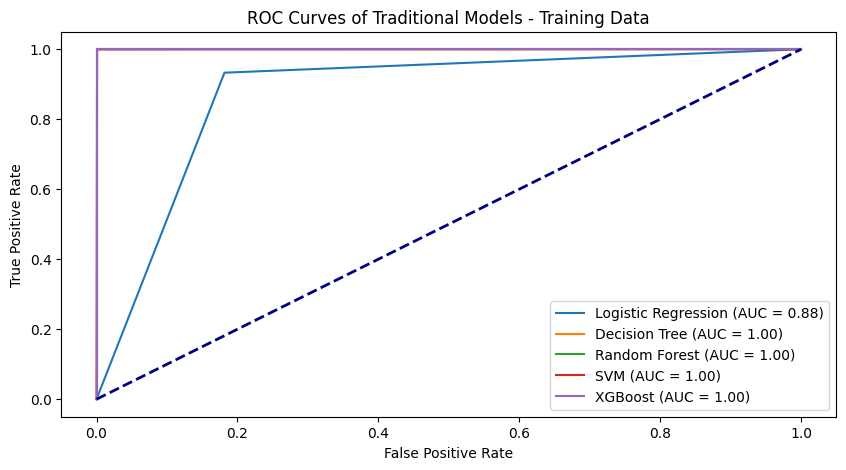

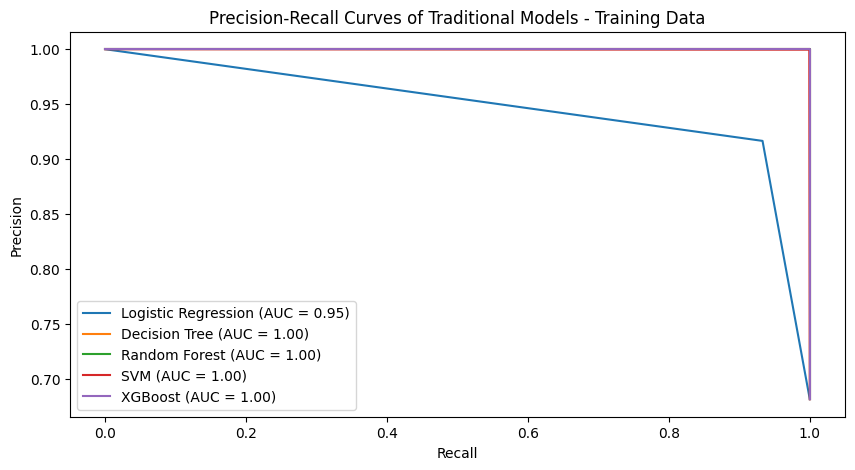

Logistic Regression Accuracy: 0.8963937418017984
Decision Tree Accuracy: 1.0
Random Forest Accuracy: 1.0
SVM Accuracy: 0.9992585974183982
XGBoost Accuracy: 1.0


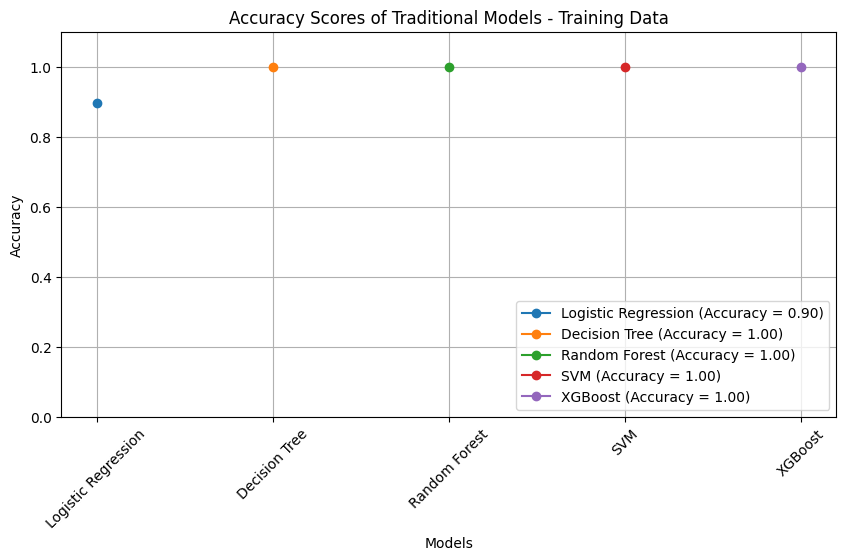

In [6]:
# Traditional Supervised Learning models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()
}

# Train and evaluate the models 
roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict = train_and_evaluate_models(models, X_train, X_test, y_train, y_test)
    
plot_evaluation_curves(roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict, 'Traditional Models')

/Users/sanjithapathuri/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


MLP Classifier Accuracy: 0.9999809896773948
MLP Classifier Confusion Matrix:
 [[16771     1]
 [    0 35831]]
MLP Classifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16772
           1       1.00      1.00      1.00     35831

    accuracy                           1.00     52603
   macro avg       1.00      1.00      1.00     52603
weighted avg       1.00      1.00      1.00     52603



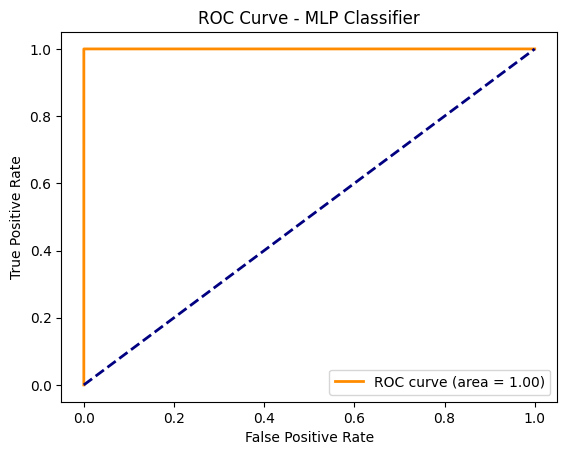

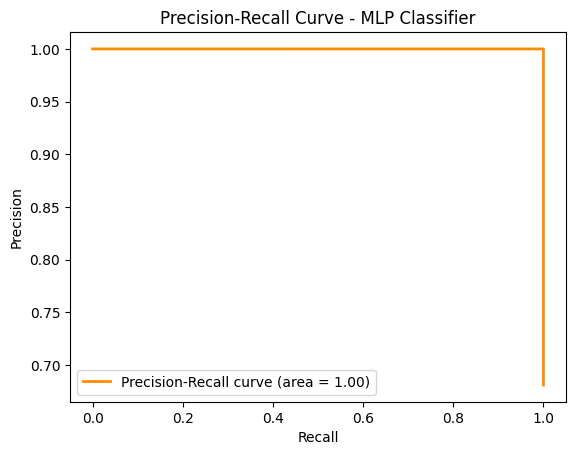

3836/3836 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step - accuracy: 0.9503 - loss: 0.1191
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step
Convolutional Neural Network (CNN) Accuracy: 0.9991825561279775
Convolutional Neural Network (CNN) Confusion Matrix:
 [[16770     2]
 [   41 35790]]
Convolutional Neural Network (CNN) Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16772
           1       1.00      1.00      1.00     35831

    accuracy                           1.00     52603
   macro avg       1.00      1.00      1.00     52603
weighted avg       1.00      1.00      1.00     52603



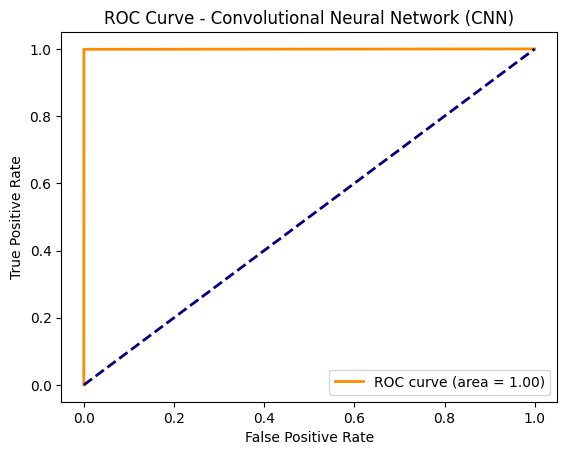

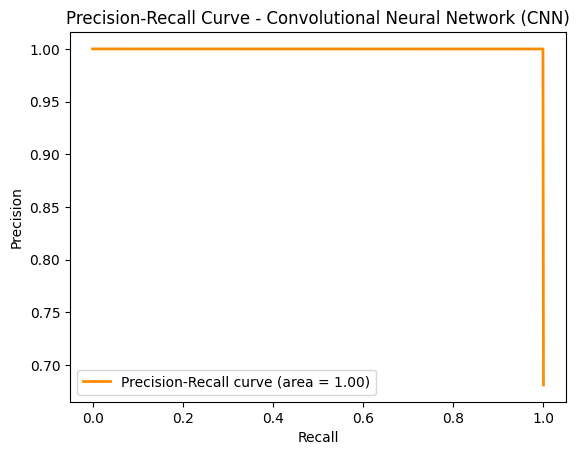

3836/3836 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9434 - loss: 0.1348
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step
Recurrent Convolutional Neural Network (RCNN) Accuracy: 0.9992966180636086
Recurrent Convolutional Neural Network (RCNN) Confusion Matrix:
 [[16762    10]
 [   27 35804]]
Recurrent Convolutional Neural Network (RCNN) Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16772
           1       1.00      1.00      1.00     35831

    accuracy                           1.00     52603
   macro avg       1.00      1.00      1.00     52603
weighted avg       1.00      1.00      1.00     52603



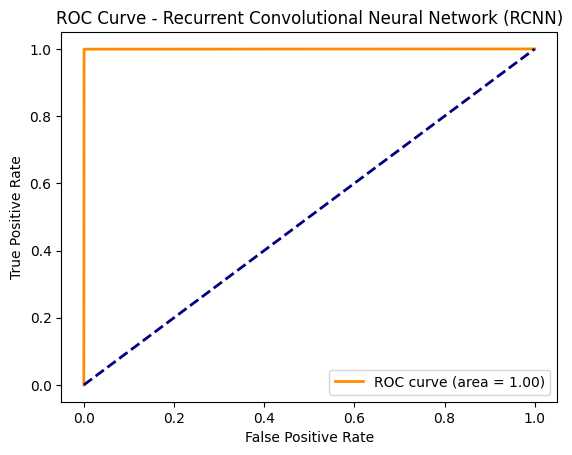

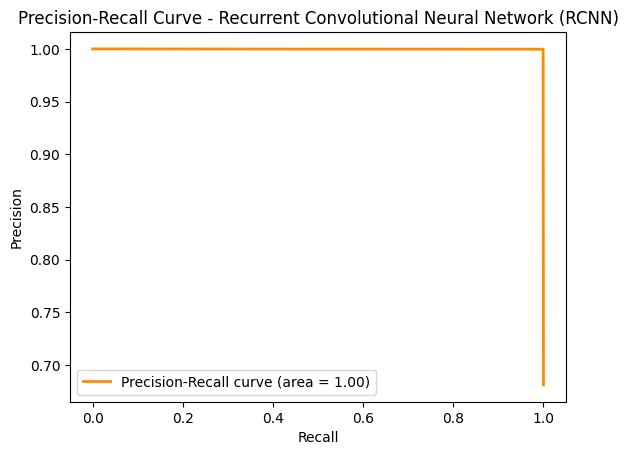

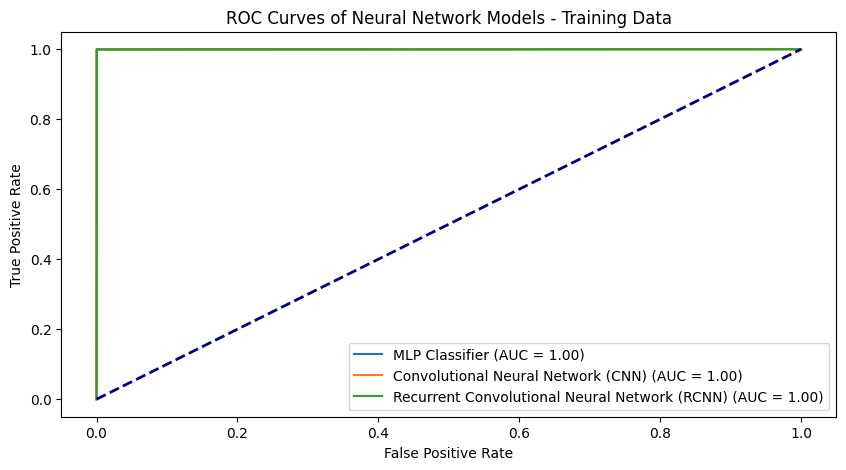

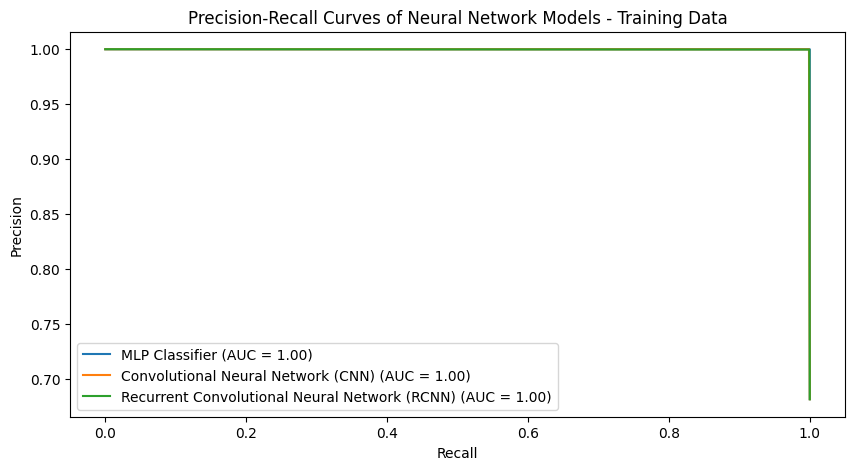

MLP Classifier Accuracy: 0.9999809896773948
Convolutional Neural Network (CNN) Accuracy: 0.9991825561279775
Recurrent Convolutional Neural Network (RCNN) Accuracy: 0.9992966180636086


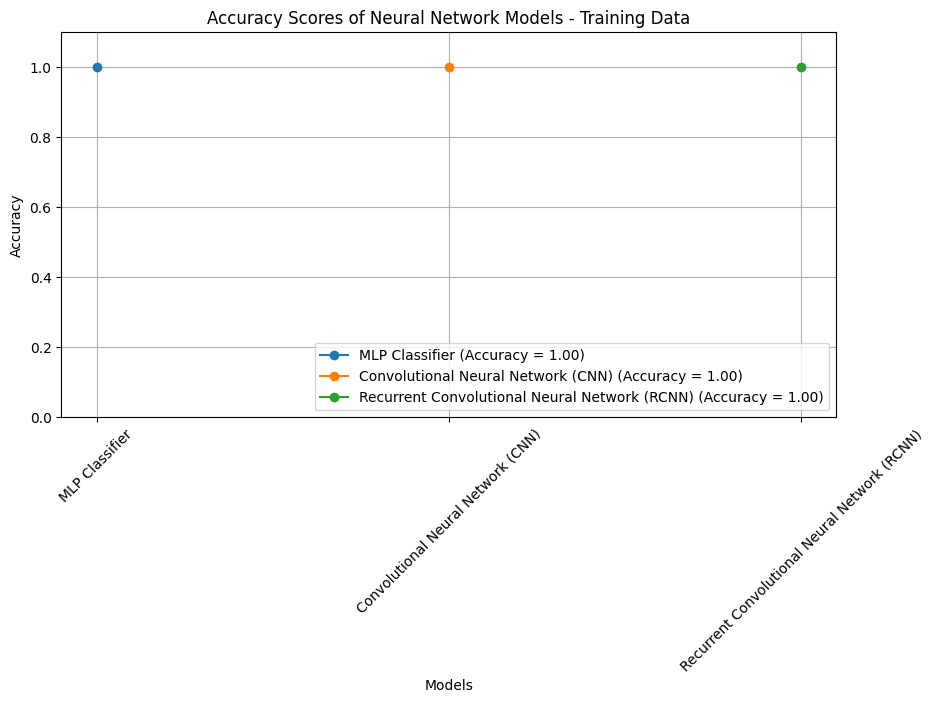

In [7]:
# Neural Network models
mlp = MLPClassifier()

cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

rcnn = Sequential()
rcnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
rcnn.add(MaxPooling1D(pool_size=2))
rcnn.add(LSTM(100))
rcnn.add(Dense(1, activation='sigmoid'))

# Neural network models
nn_models = {
    'MLP Classifier': mlp,
    'Convolutional Neural Network (CNN)': cnn,
    'Recurrent Convolutional Neural Network (RCNN)': rcnn
}

# Train and evaluate the neural network models 
roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict = train_and_evaluate_models(nn_models, X_train, X_test, y_train, y_test)
    
plot_evaluation_curves(roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict, 'Neural Network Models')